<img src='https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQ-VfNtOyJbsaxu43Kztf_cv1mgBG6ZIQZEVw&usqp=CAU'>

# Procesamiento de Lenguage Natural

# Fabio Peña Santiago

## Taller #6: Word2Vec
`Fecha de entrega: Septiembre 19, 2020. (Antes del inicio de la próxima clase).`

`Modo de entrega: Subir link de GitHub al aula virtual.`



## Libre elección

Expectativas:
- Uso de Word2Vec 
- Responder:
    - ¿Su modelo da buenos resultados? ¿Por qué sí o por qué no?
    - ¿Qué problemas encontró al realizar este taller?
    

In [1]:
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
from nltk.corpus import stopwords

from gensim.models import Word2Vec
from gensim.models import Phrases
from gensim.models.phrases import Phraser

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

%matplotlib inline

## Data

In [2]:
data = pd.read_csv('C:/Users/ITHELATH/Documents/Laptop Col/dektop/NLP/Taller 6/hotel-reviews.csv')

In [3]:
data.head()

,User_ID,Description,Browser_Used,Device_Used,Is_Response
0,id10326,The room was kind of clean but had a VERY stro...,Edge,Mobile,not happy
1,id10327,I stayed at the Crown Plaza April -- - April -...,Internet Explorer,Mobile,not happy
2,id10328,I booked this hotel through Hotwire at the low...,Mozilla,Tablet,not happy
3,id10329,Stayed here with husband and sons on the way t...,InternetExplorer,Desktop,happy
4,id10330,My girlfriends and I stayed here to celebrate ...,Edge,Tablet,not happy


In [4]:
data.describe()

,User_ID,Description,Browser_Used,Device_Used,Is_Response
count,38932,38932,38932,38932,38932
unique,38932,38932,11,3,2
top,id30082,I recently had the pleasure of staying at the ...,Firefox,Desktop,happy
freq,1,1,7367,15026,26521


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38932 entries, 0 to 38931
Data columns (total 5 columns):
User_ID         38932 non-null object
Description     38932 non-null object
Browser_Used    38932 non-null object
Device_Used     38932 non-null object
Is_Response     38932 non-null object
dtypes: object(5)
memory usage: 1.5+ MB


In [86]:
stopWords = stopwords.words('english')
def cleanData(sentence):
    processedList = ""
    sentence = re.sub(r'[^A-Za-z0-9\s.]',r'',str(sentence).lower()) #convert a minúsculas,ignorar todos los caracteres especiales 
    sentence = re.sub(r'\n',r' ',sentence)
    sentence = " ".join([word for word in sentence.split() if word not in stopWords]) # Palabras vacias
    return sentence

In [87]:
cleanData(data['Description'][5])

'rooms. one nice clearly updated recently other. clean bed comfy needed updating carpet old wrinkled example. great location visiting inner harbor getting fells point orioles games etc. supershuttle bwi worked great ways. tv remotes rooms terrible didnt watch much tv big deal. wireless sketchy th th floors didnt need much vacation didnt really matter. breakfast good morning. would stay town.'

In [88]:
# clean data 
data['Description'] = data['Description'].map(lambda x: cleanData(x))

In [89]:
data.head()

,User_ID,Description,Browser_Used,Device_Used,Is_Response
0,id10326,room kind clean strong smell dogs. generally a...,Edge,Mobile,not happy
1,id10327,stayed crown plaza april april . staff friendl...,Internet Explorer,Mobile,not happy
2,id10328,booked hotel hotwire lowest price could find. ...,Mozilla,Tablet,not happy
3,id10329,stayed husband sons way alaska cruise. loved h...,InternetExplorer,Desktop,happy
4,id10330,girlfriends stayed celebrate th birthdays. pla...,Edge,Tablet,not happy


# Word2Vec

In [90]:
tmp_corpus = data['Description'].map(lambda x: x.split('.'))

In [91]:
# corpus [[w1,w2,w3..],[..]]
corpus = []
for i in tqdm(range(len(tmp_corpus))):
    for line in tmp_corpus[i]:
        words = [x for x in line.split()]
        corpus.append(words)

100%|█████████████████████████████████████████████████████████████████████████| 38932/38932 [00:02<00:00, 16362.06it/s]


In [92]:
num_of_sentences = len(corpus)
num_of_words = 0
for line in corpus:
    num_of_words += len(line)

print('Numero de frases - %s'%(num_of_sentences))
print('Numero de palabras - %s'%(num_of_words))

Numero de frases - 444271
Numero de palabras - 3111121


Extrayendo frases del corpus Limitado por bigrama

In [95]:
phrases = Phrases(sentences=corpus,min_count=25,threshold=50)
bigram = Phraser(phrases)

2020-09-25 22:05:24,429 : INFO : collecting all words and their counts
2020-09-25 22:05:24,430 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2020-09-25 22:05:24,581 : INFO : PROGRESS: at sentence #10000, processed 70801 words and 55905 word types
2020-09-25 22:05:24,726 : INFO : PROGRESS: at sentence #20000, processed 141274 words and 98827 word types
2020-09-25 22:05:24,873 : INFO : PROGRESS: at sentence #30000, processed 212516 words and 137942 word types
2020-09-25 22:05:25,022 : INFO : PROGRESS: at sentence #40000, processed 282042 words and 173306 word types
2020-09-25 22:05:25,178 : INFO : PROGRESS: at sentence #50000, processed 351277 words and 206238 word types
2020-09-25 22:05:25,317 : INFO : PROGRESS: at sentence #60000, processed 421236 words and 238626 word types
2020-09-25 22:05:25,497 : INFO : PROGRESS: at sentence #70000, processed 491663 words and 270170 word types
2020-09-25 22:05:25,649 : INFO : PROGRESS: at sentence #80000, processed 563363 wo

In [96]:
for index,sentence in enumerate(corpus):
    corpus[index] = bigram[sentence]

Entrenamiento de modelo con Gensim

In [99]:
# sg - skip gram |  window = size of the window | size = vector dimension
size = 100
window_size = 2 
epochs = 100
min_count = 2
workers = 4
model = Word2Vec(corpus, sg=1,window=window_size,size=size,
                 min_count=min_count,workers=workers,iter=epochs,sample=0.01)

2020-09-25 22:19:25,690 : INFO : collecting all words and their counts
2020-09-25 22:19:25,691 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-09-25 22:19:25,721 : INFO : PROGRESS: at sentence #10000, processed 68251 words, keeping 8812 word types
2020-09-25 22:19:25,748 : INFO : PROGRESS: at sentence #20000, processed 136136 words, keeping 12451 word types
2020-09-25 22:19:25,771 : INFO : PROGRESS: at sentence #30000, processed 204641 words, keeping 15230 word types
2020-09-25 22:19:25,795 : INFO : PROGRESS: at sentence #40000, processed 271576 words, keeping 17587 word types
2020-09-25 22:19:25,818 : INFO : PROGRESS: at sentence #50000, processed 338157 words, keeping 19539 word types
2020-09-25 22:19:25,845 : INFO : PROGRESS: at sentence #60000, processed 405603 words, keeping 21363 word types
2020-09-25 22:19:25,870 : INFO : PROGRESS: at sentence #70000, processed 473392 words, keeping 23191 word types
2020-09-25 22:19:25,900 : INFO : PROGRESS: at se

2020-09-25 22:19:45,749 : INFO : EPOCH 3 - PROGRESS: at 77.50% examples, 757567 words/s, in_qsize 7, out_qsize 0
2020-09-25 22:19:46,528 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-25 22:19:46,528 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-25 22:19:46,551 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-25 22:19:46,559 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-25 22:19:46,561 : INFO : EPOCH - 3 : training on 2995867 raw words (2963903 effective words) took 3.8s, 771744 effective words/s
2020-09-25 22:19:47,572 : INFO : EPOCH 4 - PROGRESS: at 25.32% examples, 749299 words/s, in_qsize 7, out_qsize 0
2020-09-25 22:19:48,581 : INFO : EPOCH 4 - PROGRESS: at 52.02% examples, 768789 words/s, in_qsize 7, out_qsize 0
2020-09-25 22:19:49,595 : INFO : EPOCH 4 - PROGRESS: at 81.08% examples, 794960 words/s, in_qsize 7, out_qsize 0
2020-09-25 22:19:50,270 : INFO : worker thread 

2020-09-25 22:20:22,298 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-25 22:20:22,300 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-25 22:20:22,302 : INFO : EPOCH - 12 : training on 2995867 raw words (2963903 effective words) took 3.7s, 803698 effective words/s
2020-09-25 22:20:23,331 : INFO : EPOCH 13 - PROGRESS: at 25.32% examples, 739978 words/s, in_qsize 8, out_qsize 0
2020-09-25 22:20:24,331 : INFO : EPOCH 13 - PROGRESS: at 52.69% examples, 771642 words/s, in_qsize 7, out_qsize 0
2020-09-25 22:20:25,352 : INFO : EPOCH 13 - PROGRESS: at 80.11% examples, 781405 words/s, in_qsize 8, out_qsize 0
2020-09-25 22:20:26,019 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-25 22:20:26,047 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-25 22:20:26,053 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-25 22:20:26,062 : INFO : worker thread finished; awaiting

2020-09-25 22:20:59,572 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-25 22:20:59,585 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-25 22:20:59,603 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-25 22:20:59,605 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-25 22:20:59,606 : INFO : EPOCH - 22 : training on 2995867 raw words (2963903 effective words) took 3.7s, 803656 effective words/s
2020-09-25 22:21:00,621 : INFO : EPOCH 23 - PROGRESS: at 24.02% examples, 708076 words/s, in_qsize 8, out_qsize 0
2020-09-25 22:21:01,629 : INFO : EPOCH 23 - PROGRESS: at 48.01% examples, 708166 words/s, in_qsize 7, out_qsize 0
2020-09-25 22:21:02,632 : INFO : EPOCH 23 - PROGRESS: at 72.15% examples, 708361 words/s, in_qsize 7, out_qsize 0
2020-09-25 22:21:03,634 : INFO : EPOCH 23 - PROGRESS: at 96.03% examples, 709115 words/s, in_qsize 6, out_qsize 1
2020-09-25 22:21:03,745 : INFO : worker th

2020-09-25 22:21:35,762 : INFO : EPOCH 32 - PROGRESS: at 25.32% examples, 746841 words/s, in_qsize 7, out_qsize 0
2020-09-25 22:21:36,763 : INFO : EPOCH 32 - PROGRESS: at 52.02% examples, 764146 words/s, in_qsize 7, out_qsize 0
2020-09-25 22:21:37,798 : INFO : EPOCH 32 - PROGRESS: at 78.14% examples, 760532 words/s, in_qsize 8, out_qsize 0
2020-09-25 22:21:38,626 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-25 22:21:38,657 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-25 22:21:38,659 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-25 22:21:38,672 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-25 22:21:38,674 : INFO : EPOCH - 32 : training on 2995867 raw words (2963903 effective words) took 3.9s, 756523 effective words/s
2020-09-25 22:21:39,698 : INFO : EPOCH 33 - PROGRESS: at 24.65% examples, 723683 words/s, in_qsize 7, out_qsize 0
2020-09-25 22:21:40,696 : INFO : EPOCH 33 

2020-09-25 22:22:13,779 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-25 22:22:13,784 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-25 22:22:13,786 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-25 22:22:13,787 : INFO : EPOCH - 41 : training on 2995867 raw words (2963903 effective words) took 3.8s, 778806 effective words/s
2020-09-25 22:22:14,801 : INFO : EPOCH 42 - PROGRESS: at 24.99% examples, 737290 words/s, in_qsize 7, out_qsize 0
2020-09-25 22:22:15,809 : INFO : EPOCH 42 - PROGRESS: at 52.69% examples, 777488 words/s, in_qsize 7, out_qsize 0
2020-09-25 22:22:16,815 : INFO : EPOCH 42 - PROGRESS: at 79.13% examples, 777121 words/s, in_qsize 7, out_qsize 0
2020-09-25 22:22:17,560 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-25 22:22:17,573 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-25 22:22:17,583 : INFO : worker thread finished; awaiting

2020-09-25 22:22:51,120 : INFO : EPOCH 51 - PROGRESS: at 53.35% examples, 784064 words/s, in_qsize 7, out_qsize 0
2020-09-25 22:22:52,115 : INFO : EPOCH 51 - PROGRESS: at 79.45% examples, 778998 words/s, in_qsize 7, out_qsize 0
2020-09-25 22:22:52,890 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-25 22:22:52,904 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-25 22:22:52,918 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-25 22:22:52,920 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-25 22:22:52,922 : INFO : EPOCH - 51 : training on 2995867 raw words (2963903 effective words) took 3.8s, 777355 effective words/s
2020-09-25 22:22:53,938 : INFO : EPOCH 52 - PROGRESS: at 26.62% examples, 787890 words/s, in_qsize 7, out_qsize 0
2020-09-25 22:22:54,953 : INFO : EPOCH 52 - PROGRESS: at 52.02% examples, 764328 words/s, in_qsize 8, out_qsize 0
2020-09-25 22:22:55,964 : INFO : EPOCH 52 

2020-09-25 22:23:29,123 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-25 22:23:29,123 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-25 22:23:29,138 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-25 22:23:29,150 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-25 22:23:29,151 : INFO : EPOCH - 60 : training on 2995867 raw words (2963903 effective words) took 3.8s, 780718 effective words/s
2020-09-25 22:23:30,195 : INFO : EPOCH 61 - PROGRESS: at 24.65% examples, 708962 words/s, in_qsize 6, out_qsize 1
2020-09-25 22:23:31,230 : INFO : EPOCH 61 - PROGRESS: at 51.02% examples, 732026 words/s, in_qsize 6, out_qsize 1
2020-09-25 22:23:32,232 : INFO : EPOCH 61 - PROGRESS: at 75.17% examples, 724791 words/s, in_qsize 7, out_qsize 0
2020-09-25 22:23:33,143 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-25 22:23:33,143 : INFO : worker thread finished; awaiting

2020-09-25 22:24:05,229 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-25 22:24:05,231 : INFO : EPOCH - 69 : training on 2995867 raw words (2963903 effective words) took 4.0s, 732813 effective words/s
2020-09-25 22:24:06,251 : INFO : EPOCH 70 - PROGRESS: at 26.62% examples, 784828 words/s, in_qsize 8, out_qsize 0
2020-09-25 22:24:07,258 : INFO : EPOCH 70 - PROGRESS: at 53.03% examples, 777782 words/s, in_qsize 7, out_qsize 0
2020-09-25 22:24:08,277 : INFO : EPOCH 70 - PROGRESS: at 80.44% examples, 785309 words/s, in_qsize 7, out_qsize 0
2020-09-25 22:24:08,947 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-25 22:24:08,974 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-25 22:24:08,975 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-25 22:24:08,976 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-25 22:24:08,977 : INFO : EPOCH - 70 : training on 2995867

2020-09-25 22:24:42,708 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-25 22:24:42,710 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-25 22:24:42,718 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-25 22:24:42,719 : INFO : EPOCH - 79 : training on 2995867 raw words (2963903 effective words) took 3.8s, 781668 effective words/s
2020-09-25 22:24:43,739 : INFO : EPOCH 80 - PROGRESS: at 26.29% examples, 776800 words/s, in_qsize 7, out_qsize 0
2020-09-25 22:24:44,726 : INFO : EPOCH 80 - PROGRESS: at 55.05% examples, 812572 words/s, in_qsize 7, out_qsize 0
2020-09-25 22:24:45,754 : INFO : EPOCH 80 - PROGRESS: at 82.77% examples, 811539 words/s, in_qsize 8, out_qsize 0
2020-09-25 22:24:46,338 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-25 22:24:46,351 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-25 22:24:46,355 : INFO : worker thread finished; awaiting

2020-09-25 22:25:18,839 : INFO : EPOCH 89 - PROGRESS: at 53.35% examples, 789019 words/s, in_qsize 7, out_qsize 0
2020-09-25 22:25:19,844 : INFO : EPOCH 89 - PROGRESS: at 80.76% examples, 792805 words/s, in_qsize 7, out_qsize 0
2020-09-25 22:25:20,544 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-25 22:25:20,560 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-25 22:25:20,584 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-25 22:25:20,586 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-25 22:25:20,587 : INFO : EPOCH - 89 : training on 2995867 raw words (2963903 effective words) took 3.8s, 789751 effective words/s
2020-09-25 22:25:21,605 : INFO : EPOCH 90 - PROGRESS: at 24.98% examples, 735345 words/s, in_qsize 7, out_qsize 0
2020-09-25 22:25:22,615 : INFO : EPOCH 90 - PROGRESS: at 52.35% examples, 769398 words/s, in_qsize 7, out_qsize 0
2020-09-25 22:25:23,617 : INFO : EPOCH 90 

2020-09-25 22:25:55,228 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-25 22:25:55,229 : INFO : EPOCH - 98 : training on 2995867 raw words (2963903 effective words) took 3.7s, 800760 effective words/s
2020-09-25 22:25:56,242 : INFO : EPOCH 99 - PROGRESS: at 24.65% examples, 731031 words/s, in_qsize 7, out_qsize 0
2020-09-25 22:25:57,245 : INFO : EPOCH 99 - PROGRESS: at 51.01% examples, 753591 words/s, in_qsize 7, out_qsize 0
2020-09-25 22:25:58,257 : INFO : EPOCH 99 - PROGRESS: at 79.78% examples, 783386 words/s, in_qsize 8, out_qsize 0
2020-09-25 22:25:58,962 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-25 22:25:58,977 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-25 22:25:58,995 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-25 22:25:59,002 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-25 22:25:59,003 : INFO : EPOCH - 99 : training on 2995867

In [100]:
model.save('w2v_model')

2020-09-25 22:30:52,804 : INFO : saving Word2Vec object under w2v_model, separately None
2020-09-25 22:30:52,805 : INFO : not storing attribute vectors_norm
2020-09-25 22:30:52,806 : INFO : not storing attribute cum_table
2020-09-25 22:30:53,045 : INFO : saved w2v_model


In [101]:
model = Word2Vec.load('w2v_model')

2020-09-25 22:31:00,342 : INFO : loading Word2Vec object from w2v_model
2020-09-25 22:31:00,568 : INFO : loading wv recursively from w2v_model.wv.* with mmap=None
2020-09-25 22:31:00,569 : INFO : setting ignored attribute vectors_norm to None
2020-09-25 22:31:00,570 : INFO : loading vocabulary recursively from w2v_model.vocabulary.* with mmap=None
2020-09-25 22:31:00,571 : INFO : loading trainables recursively from w2v_model.trainables.* with mmap=None
2020-09-25 22:31:00,573 : INFO : setting ignored attribute cum_table to None
2020-09-25 22:31:00,574 : INFO : loaded w2v_model


## Prueba de Modelo TOP 3

In [102]:
model.wv.most_similar(positive=['man', 'queen'], negative=['women'], topn=3)

2020-09-25 22:31:06,280 : INFO : precomputing L2-norms of word weight vectors


[('king', 0.6565696001052856),
 ('king_size', 0.5799823999404907),
 ('king_sized', 0.5737249851226807)]

In [103]:
model.wv.most_similar(positive=['hotel', 'room'], negative=['cafe'], topn=3)

[('property', 0.4965765178203583),
 ('accommodation', 0.4946577250957489),
 ('newlyrenovated', 0.45262718200683594)]

In [104]:
model.wv.most_similar(positive=['happy', 'sad'], negative=['annoy'], topn=3)

[('excited', 0.5196446180343628),
 ('pleased', 0.5049136877059937),
 ('disappointed', 0.44200944900512695)]

### Resultados por Palabra clave

In [107]:
model.wv.doesnt_match('hotel nice clean'.split())

'hotel'

In [108]:
model.wv.doesnt_match('breakfast dinner continental lunch'.split())

'continental'

In [109]:
model.wv.similarity('dinner','lunch')

0.76888686

In [110]:
model.wv.similarity('hotel','clean')

0.21856992

In [111]:
model.wv.most_similar('perfect')

[('ideal', 0.7670559883117676),
 ('great', 0.6741278767585754),
 ('brilliant', 0.6500482559204102),
 ('excellent', 0.6226468086242676),
 ('wonderful', 0.6188117265701294),
 ('roomnice', 0.6086671948432922),
 ('superb', 0.6061738729476929),
 ('terrific', 0.6009649038314819),
 ('fantastic', 0.599994957447052),
 ('accessability', 0.5985549688339233)]

In [112]:
model.wv.most_similar('spacious')

[('roomy', 0.7971757054328918),
 ('large', 0.7285640239715576),
 ('well_appointed', 0.7206459641456604),
 ('spacous', 0.7116336822509766),
 ('roombath', 0.7101600766181946),
 ('goodsize', 0.6990399360656738),
 ('cleam', 0.6947033405303955),
 ('incredable', 0.6911747455596924),
 ('confy', 0.6879125237464905),
 ('apportioned', 0.6848894357681274)]

In [113]:
model.wv.most_similar('recommend')

[('highly_recommend', 0.8238503336906433),
 ('recomend', 0.8000187873840332),
 ('reccomend', 0.7726543545722961),
 ('recommed', 0.7598069310188293),
 ('reccommend', 0.7544780969619751),
 ('suggest', 0.7491920590400696),
 ('recommned', 0.6948679685592651),
 ('edited', 0.6572692394256592),
 ('recoomend', 0.6539791226387024),
 ('hesistate', 0.6516320109367371)]

In [114]:
model.wv.most_similar('natural')

[('sciences', 0.5128594636917114),
 ('specialities', 0.49903154373168945),
 ('sutro', 0.4851619303226471),
 ('croquet', 0.48510968685150146),
 ('yadda', 0.46553629636764526),
 ('coldhot', 0.45534175634384155),
 ('winged', 0.4542667865753174),
 ('panoramic', 0.451122522354126),
 ('fruit_salad', 0.4467257559299469),
 ('grammy', 0.4463244080543518)]

In [115]:
model.wv.most_similar('love')

[('loved', 0.7054936289787292),
 ('liked', 0.5951526761054993),
 ('adore', 0.5891929864883423),
 ('kimption', 0.5746123790740967),
 ('enjoyed', 0.5512884259223938),
 ('enjoy', 0.5295683145523071),
 ('overdrive', 0.5241472721099854),
 ('implore', 0.5185259580612183),
 ('awesome', 0.5178641080856323),
 ('hearbeat', 0.4972344934940338)]

In [116]:
model.wv.most_similar('wife')

[('husband', 0.9216257333755493),
 ('daughter', 0.7049850225448608),
 ('boyfriend', 0.6844373941421509),
 ('son', 0.6691243648529053),
 ('partner', 0.661523163318634),
 ('fiance', 0.6566592454910278),
 ('girlfriend', 0.6499475836753845),
 ('friend', 0.638625979423523),
 ('mother', 0.624932587146759),
 ('mom', 0.6126346588134766)]

In [117]:
model.wv.most_similar('new')

[('brand_new', 0.6232224702835083),
 ('updated', 0.5446164011955261),
 ('newer', 0.5306969881057739),
 ('renovated', 0.5237247943878174),
 ('newly', 0.5162885785102844),
 ('shiny', 0.5022820234298706),
 ('newly_remodeled', 0.4964227080345154),
 ('refurbished', 0.49325621128082275),
 ('wplenty', 0.49053195118904114),
 ('spanking', 0.4861977696418762)]

- Responder:
    - ¿Su modelo da buenos resultados? ¿Por qué sí o por qué no?
    
    Los resutados me parecen aceptables, porque al buscar la relacion de palabras los resultados son acertados.
    
    
    
    - ¿Qué problemas encontró al realizar este taller?
    
    Intente con varias Datas mas grades y creo que para este tipo de Modelos es necesario contar con una buena maquina, ya que al ver el el procesamiento  de maquina consume muchos recursos, y pues si voy a trabajar con volumnes grandes de informacion, ya me tocaria apuntar a servers o nube.

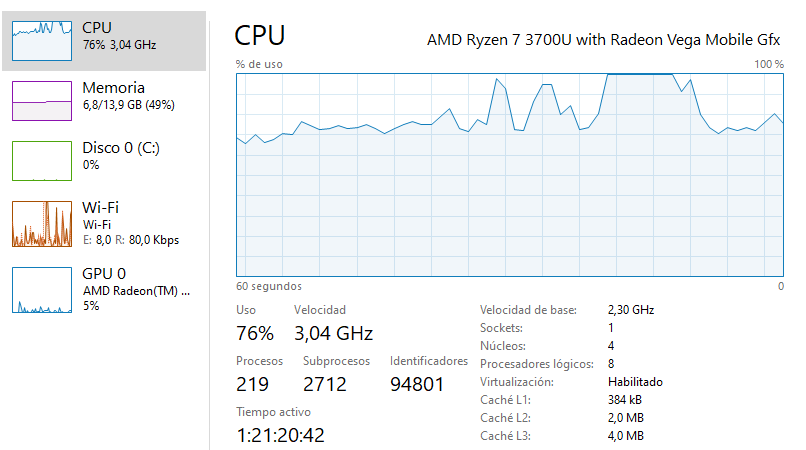

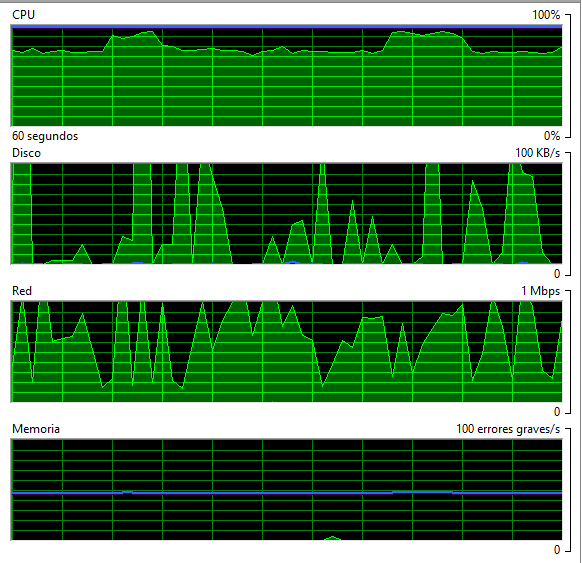